In [1]:
# imports
import seaborn as sbn
import json, re, time, unicodedata, unidecode, codecs, random, math, warnings
from pprint import pprint
from lxml import etree
from pattern.nl import parse, split, parsetree
from collections import defaultdict, Counter
from datetime import date, datetime, timedelta
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from pattern.nl import sentiment
import pandas as pd
from scipy.stats.mstats import normaltest
from tqdm import *

In [2]:
# files
#MWE
#topics = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\MWE_topic.json'))
#posts = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\MWE.json'))
#regular
forums = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-35-45 _amazones_forums_export.json'))
topics = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-36-51_amazones_forum_topics_export.json'))
posts = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-39-20_amazones_forum_posts_export.json'))
users = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-39-20_amazones_users_export.json'))

In [3]:
# remove non-ascii characters from file (otherwise they will become part of the tokens)
def remove_non_ascii(text):
    return unidecode.unidecode(text)
    #return ''.join([i if ord(i) < 128 else ' ' for i in text])

In [4]:
def cleanup(text):
    #remove all links, images, quotes, and emailaddresses
    text=re.sub('<a.*?>(.*?)</a>','',text) #remove links
    text=re.sub('(http:|www)\S*','',text) #remove links without markup
    text=re.sub('\[\\\/url\]','',text)
    text=re.sub('<img.*?/>', '',text) #remove images
    text=re.sub('<div class="bb-quote">((\s|\S)*?)</div>','',text) #remove quotes
    text=re.sub('<script.*?>([\S\s]*?)</script>','',text) #remove emailaddresses

    #replace all emoticon-icons
    text=re.sub('<img.*?title="(.*?)".*?/>', '(EMO:\\1)',text) #replace emoticons by textual indicators 

    # replace (most) sideways latin emoticons
    text=re.sub('[^>]:-?(\)|\])','(EMO:smiley)',text)
    text=re.sub(u'☺️','(EMO:smiley)',text)
    text=re.sub('[^>]:-?(\(|\[)','(EMO:sad)',text)
    text=re.sub(';-?(\)|\])','(EMO:wink)',text)
    text=re.sub(r'(:|;|x|X)-?(D)+\b','(EMO:laugh)',text)
    text=re.sub(':-?(/|\\\|\|)','(EMO:frown)',text)
    text=re.sub(r'(:|;)-?(p|P)+\b','(EMO:cheeky)',text)
    text=re.sub('(:|;)(\'|\")-?(\(|\[)','(EMO:cry)',text)
    text=re.sub('\<3+','(EMO:heart)',text)
    text=re.sub(u'❤️','(EMO:heart)',text)
    text=re.sub('((\>:-?(\(|\]))|(\>?:-?@))','(EMO:angry)',text)
    text=re.sub('\>:-?(\)|\])','(EMO:evil)',text)
    text=re.sub(r'(:|;)-?(O|o|0)+\b','(EMO:shock)',text)
    text=re.sub('(:|;)-?(K|k|x|X)','(EMO:kiss)',text)
    # :s
    # :x is eigenlijk geen kus, geloof ik...


    #other important adjustments:
    text=re.sub('m\'?n\s','mijn ',text) # replacing m'n and mn with mijn, so it gets parsed correctly.
    text=re.sub('z\'?n\s','zijn ',text) #replacing z'n and zn with zijn
    text=re.sub('d\'?r\s','haar ',text) #replacing d'r and dr with zijn (only if followed by space, so dr. stays dr.)

    # replace all emoticons (and other things) written between double colons
    text=re.sub(':([a-zA-Z]+):','(EMO:\\1)',text)

    # remove remaining markup
    text=re.sub('</?(ol|style|b|p|em|u|i|strong|br|span|div|blockquote|li)(.*?)/?>','',text)
    text=re.sub('(\[|\]|\{|\})', '',text)

    # separate text from punctuation (may cause double/triple spaces - does not matter at this point)
    text = re.sub('(\.{2,}|/|\)|,|!|\?)','\\1 ',text) # space behind
    text=re.sub('(/|\()',' \\1',text) # space in front
    text=re.sub('(\w{2,})(\.|,)','\\1 \\2 ',text) #space 'between'

    return(text)

In [5]:
# make two dictionaries: user's post T imes, and user's P ost texts.
def make_P_T_and_D(topics,posts,count=2500):
    P = defaultdict(list)
    T = defaultdict(list)
    D = []

    for t in reversed(topics):    
        P[t['Author uid']].append((remove_non_ascii(cleanup(t["Body"])),1))
        T[t['Author uid']].append(t['Post date'])
        D.append(datetime.strptime(t['Post date'], '%d/%m/%Y - %H:%M'))

        count-=1
        if count-1<=0:
            break
        for p in reversed(posts):
            if p['Forum Topic ID'] == t['Nid']:
                P[p['Auteur-uid']].append((remove_non_ascii(cleanup(p["Body"])),0))
                T[p['Auteur-uid']].append(p['Datum van inzending'])
                D.append(datetime.strptime(p['Datum van inzending'], '%d/%m/%Y - %H:%M'))

                count-=1
                if count-1<=0:
                    break
    return (P,T,D)

In [6]:
def make_binlist(D,timetick=1): #timetick in days
    lower = min(D)
    upper = max(D)

    if lower.time()>=datetime.strptime('4:00','%H:%M').time():
        lower = lower.replace(hour = 4, minute = 0)
    else:
        lower = (lower+timedelta(days = -1)).replace(hour=4,minute=0)

    if upper.time()<datetime.strptime('12:00','%H:%M').time():
        upper = upper.replace(hour = 4, minute = 0)
    else:
        upper = (upper+timedelta(days=1)).replace(hour=4,minute=0)

        return([lower + timedelta(days=x) for x in range(0, (upper-lower).days, timetick)])

In [7]:
def determine_questionmarks(body):
    Q = 0
    for sentence in sent_tokenize(body):
        if re.search('\?+', sentence):
            Q+=1
    if len(sent_tokenize(body))!=0:
        return float(Q)/float(len(sent_tokenize(body)))
    else:
        return 0

# expects a string
# returns an int, representing the average sentiment score per sentence in the string, calculated by pattern
def determine_sentiment(body):
    S = []
    for sentence in sent_tokenize(body):
        S.append(sentiment(sentence)[0])
    return np.mean(S)

# expects a string
# returns an int, representing the average objectivity score per sentence in the string, calculated by pattern
def determine_objectivity(body):
    O = []
    for sentence in sent_tokenize(body):
        O.append(sentiment(sentence)[1])
    return np.mean(O)

# expects a string
# returns an int, representing the total nr of sentences the string is built of
def determine_length(body):
    # in sentences:
    return(len(sent_tokenize(body)))

# expects a string
# returns an int, representing the average nr of words in sentences that occur in the string
def determine_sent_length(body):
    # in words:
    L = []
    for sentence in sent_tokenize(body):
        L.append(len(word_tokenize(sentence)))
    return np.mean(L)

In [8]:
def compare_variables(pp,user,nr_of_posts,mean_quest,mean_object,mean_sents,mean_length,mean_sents_length,nr_of_starts,nr_of_responses):
    fig = plt.figure(1)
    ax = plt.subplot(111)

    posts, = ax.plot(nr_of_posts.values(),'b.', label = 'nr of posts', alpha = 1) #blue
    senlength, = ax.plot(mean_sents_length.values(),'k.', label = 'mean sentence length (words)',alpha = 0) #yellow
    postlength, = ax.plot(mean_length.values(),'c.', label = 'mean post length (sentences)',alpha = 0) #cyan
    starts, = ax.plot(nr_of_starts.values(),'g.', label = 'start posts', alpha = 0) #black
    #responses, = ax.plot(nr_of_responses.values(),'y.', label = 'response posts', alpha = 0.5)
    
    first_legend = plt.legend(handles=[posts,senlength,postlength,starts], title = "left axis", loc='upper left', bbox_to_anchor=(0, -0.1),ncol=1)
    axx = plt.gca().add_artist(first_legend)
    
    ax1 = ax.twinx()
    qmarks, = ax1.plot(mean_quest.values(),'y.', label = 'question ratio',alpha = 0) #green
    ovalues, = ax1.plot(mean_object.values(),'r.', label = 'subjectivity',alpha = 0) #red
    svalues, = ax1.plot(mean_sent.values(),'m.', label = 'sentiment',alpha = 0) #magenta
    
    
    second_legend = plt.legend(handles=[qmarks,ovalues,svalues], title = "right axis",loc='upper right', bbox_to_anchor=(1, -0.1),ncol=1)

    ax.set_ylim(0,10)
    ax1.set_ylim(-1,1)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height, box.width, box.height * 0.7])
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height, box.width, box.height * 0.7])
    
    plt.title(user)
    plt.show()
    pp.savefig(fig, dpi = 300, transparent = True)

In [19]:
def compare_two(user,x,y):
    x = x.values()
    y = y.values()
    
    plt.plot(x,y, 'bo', alpha = 0.1)
    plt.xlabel('sentiment')
    plt.ylabel('subjectivity')
    plt.xlim(-1,1)
    plt.ylim(0,1)
    plt.title("correlation plot")
    #plt.show()

In [10]:
# determine which variables are non-normal, and make a mask for correlations that are measured nonparametrically
def mask_nonnormal(df,mask):
    for column in df:
        index = df.columns.get_loc(column)
        z,p = normaltest(df[column].tolist())
        # als de data in de kolom significant niet-normaal verdeeld is, activeer dan het maskeer voor de relevante rij en kolom
        if p<0.05:
            mask[index]=True #rijen blokkeren
            mask[0::1,index]=True #kolommen blokkeren
    return mask

In [41]:
def visualise(df, method):
    global averagedict, normaldict, nonnormaldict, countnonnormal
    rho = df.corr(method = m)
    mask = np.zeros_like(rho, dtype=np.bool)
    
    if method == 'pearson' or method == 'spearman':
        mask = mask_nonnormal(df,mask)
        cmap = sbn.diverging_palette(120, 260, n=21, s=80)
        cbar_kws= dict(use_gridspec=False,location="left",label= "Pearson's Rho")
    else:
        mask = ~mask_nonnormal(df,mask)
        cmap = sbn.diverging_palette(10, 30, n=21, s=99, l=65)
        cbar_kws = dict(use_gridspec=False,location="right",label= "Kendall's Tau")

    #mask the upper half of the figure
    mask[np.triu_indices_from(mask)] = True
    
    # calculate averages        
    for i,row in enumerate(mask):
        for j,column in enumerate(row):
            if column == False: # all unmasked positions
                averagedict[i,j].append(rho.iloc[i][j])
                if method == 'pearson' or method == 'spearman':
                    normaldict[i,j].append(rho.iloc[i][j])
                else:
                    nonnormaldict[i,j].append(rho.iloc[i][j])
                    countnonnormal[i,j].append(1)
    
    # make heatmap
    ax = sbn.heatmap(rho, mask=mask, cbar_kws = cbar_kws, cmap=cmap, vmin = -1, vmax = 1, annot = True, fmt='1.2f')
    plt.title('results of (non-)parametric correlation tests')
    plt.show()

In [46]:
def show_correlations(dictionaries,countnonnormal,rho):
    for d in dictionaries:
        frame = pd.DataFrame().reindex_like(rho)
        for (i,j) in d:
            frame.iloc[i][j]=np.nanmean(d[(i,j)])
        print frame

    frame = pd.DataFrame().reindex_like(rho)
    for (i,j) in countnonnormal:
        frame.iloc[i][j]=np.nansum(countnonnormal[(i,j)])
    print frame

In [12]:
PTD = make_P_T_and_D(topics,posts) 
P = PTD[0]
T = PTD[1]
D = PTD[2]

  0%|                                                                                          | 0/307 [00:00<?, ?it/s]

User:  1783 - Active bins:  39


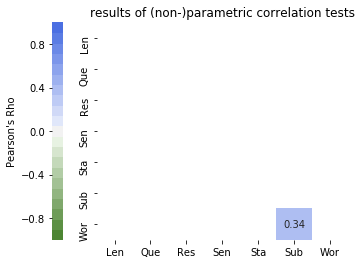

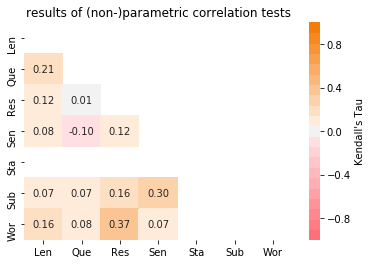

  3%|██▏                                                                               | 8/307 [00:03<02:04,  2.40it/s]

User:  1370 - Active bins:  99


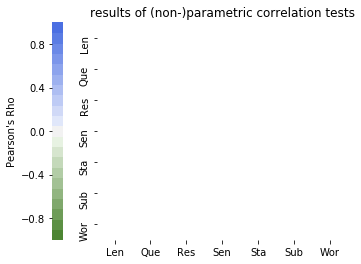

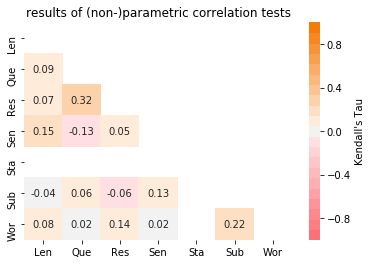

  8%|██████▎                                                                          | 24/307 [00:09<01:55,  2.44it/s]

User:  934 - Active bins:  32


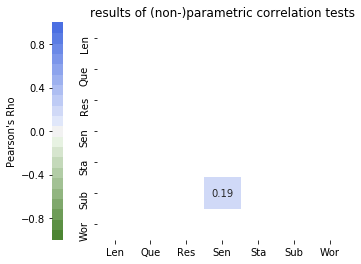

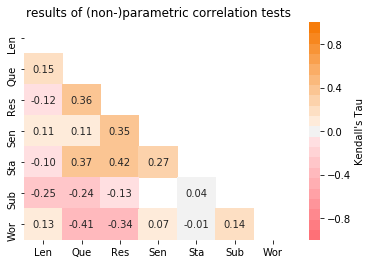

 11%|█████████▏                                                                       | 35/307 [00:12<01:35,  2.86it/s]

User:  1312 - Active bins:  31


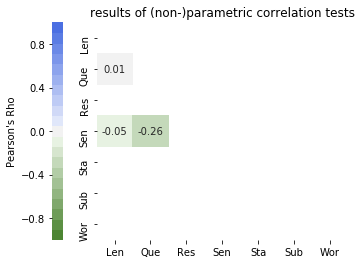

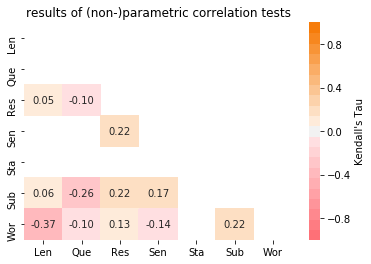

 13%|██████████▌                                                                      | 40/307 [00:14<01:37,  2.75it/s]

User:  1015 - Active bins:  44


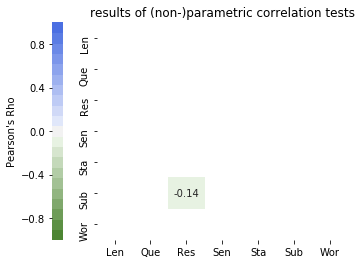

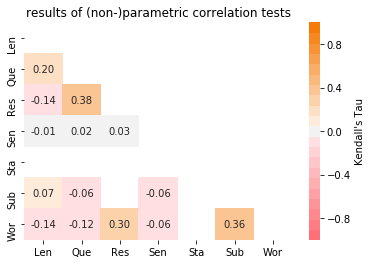

 16%|████████████▉                                                                    | 49/307 [00:17<01:32,  2.78it/s]

User:  1825 - Active bins:  47


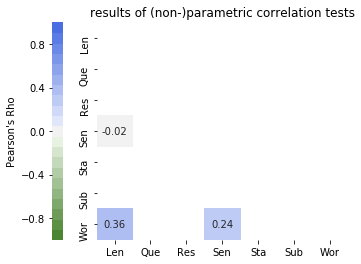

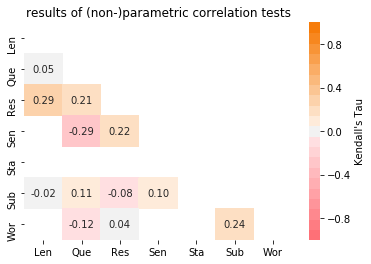

 19%|███████████████▌                                                                 | 59/307 [00:20<01:27,  2.83it/s]

User:  1062 - Active bins:  102


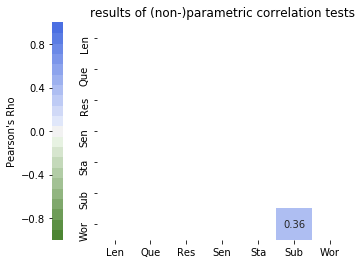

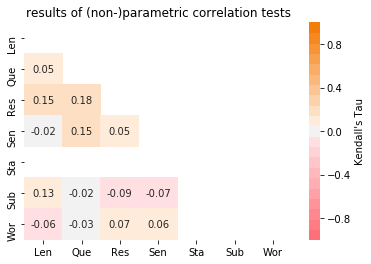

 20%|████████████████▎                                                                | 62/307 [00:26<01:46,  2.31it/s]

User:  1405 - Active bins:  41


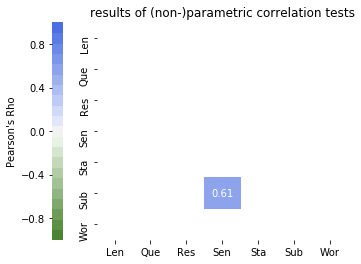

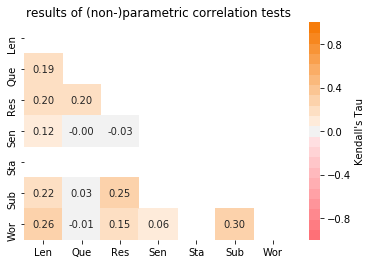

 23%|██████████████████▍                                                              | 70/307 [00:29<01:40,  2.36it/s]

User:  902 - Active bins:  119


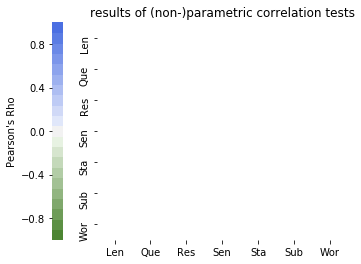

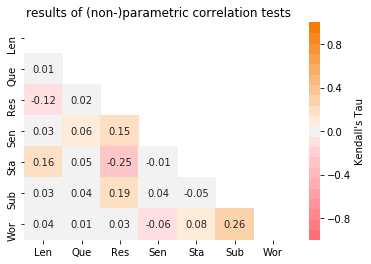

 43%|██████████████████████████████████▍                                             | 132/307 [00:36<00:48,  3.62it/s]

User:  901 - Active bins:  67


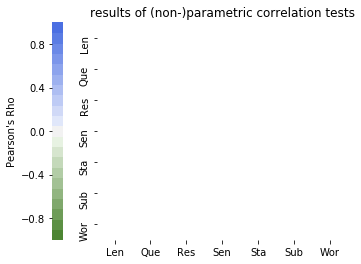

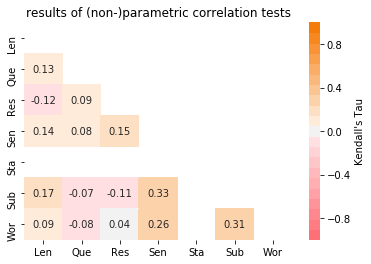

 44%|██████████████████████████████████▉                                             | 134/307 [00:40<00:52,  3.29it/s]

User:  1000 - Active bins:  83


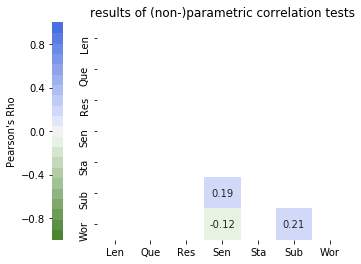

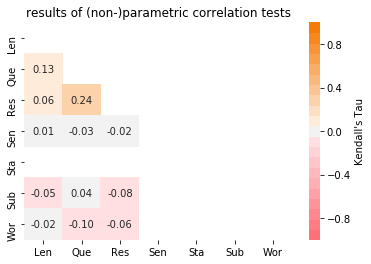

 50%|███████████████████████████████████████▊                                        | 153/307 [00:45<00:46,  3.35it/s]

User:  1503 - Active bins:  74


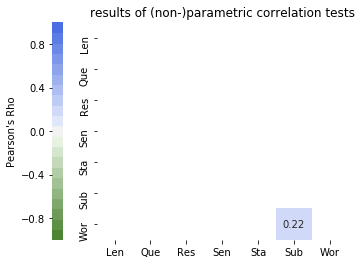

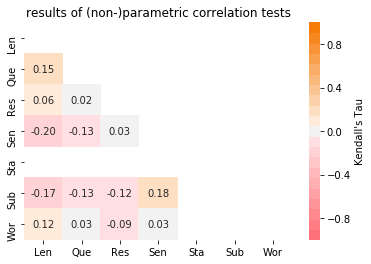

 60%|███████████████████████████████████████████████▉                                | 184/307 [00:50<00:33,  3.66it/s]

User:  1033 - Active bins:  52


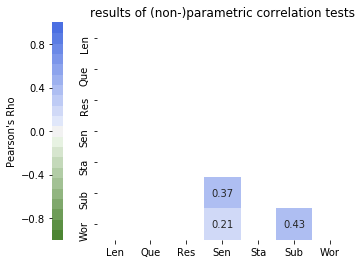

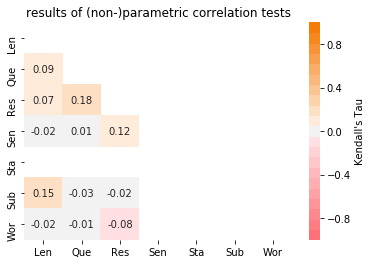

 61%|████████████████████████████████████████████████▉                               | 188/307 [00:53<00:34,  3.49it/s]

User:  905 - Active bins:  143


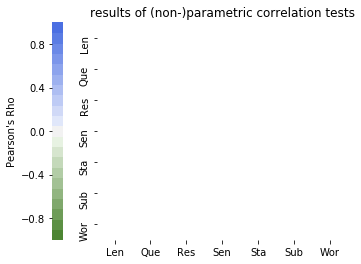

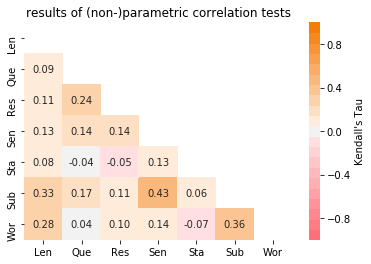

 70%|████████████████████████████████████████████████████████                        | 215/307 [01:01<00:26,  3.47it/s]

User:  1 - Active bins:  81


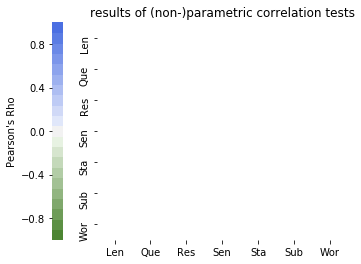

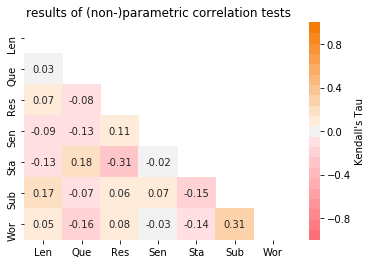

 84%|███████████████████████████████████████████████████████████████████▍            | 259/307 [01:07<00:12,  3.86it/s]

User:  6131 - Active bins:  35


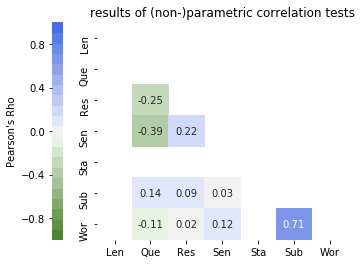

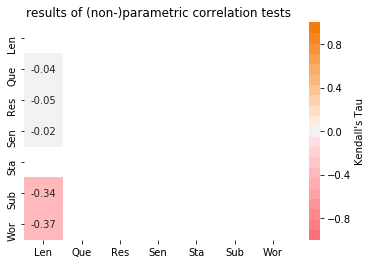

100%|████████████████████████████████████████████████████████████████████████████████| 307/307 [01:09<00:00,  4.41it/s]


          Len       Que       Res       Sen       Sta       Sub  Wor
Len       NaN       NaN       NaN       NaN       NaN       NaN  NaN
Que  0.096171       NaN       NaN       NaN       NaN       NaN  NaN
Res  0.044724  0.126352       NaN       NaN       NaN       NaN  NaN
Sen  0.021863 -0.055220  0.119295       NaN       NaN       NaN  NaN
Sta  0.002655  0.138014 -0.048670  0.095806       NaN       NaN  NaN
Sub  0.032889 -0.013662  0.016459  0.187864 -0.023641       NaN  NaN
Wor  0.037340 -0.066015  0.056168  0.053696 -0.034101  0.312282  NaN


C:\Users\sternheimam\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


          Len       Que       Res       Sen  Sta      Sub  Wor
Len       NaN       NaN       NaN       NaN  NaN      NaN  NaN
Que  0.011225       NaN       NaN       NaN  NaN      NaN  NaN
Res       NaN -0.245445       NaN       NaN  NaN      NaN  NaN
Sen -0.034019 -0.324978  0.216310       NaN  NaN      NaN  NaN
Sta       NaN       NaN       NaN       NaN  NaN      NaN  NaN
Sub       NaN  0.137046 -0.021356  0.278110  NaN      NaN  NaN
Wor  0.363022 -0.110638  0.017383  0.110693  NaN  0.37746  NaN
          Len       Que       Res       Sen       Sta       Sub  Wor
Len       NaN       NaN       NaN       NaN       NaN       NaN  NaN
Que  0.101834       NaN       NaN       NaN       NaN       NaN  NaN
Res  0.044724  0.151138       NaN       NaN       NaN       NaN  NaN
Sen  0.029846 -0.016684  0.112828       NaN       NaN       NaN  NaN
Sta  0.002655  0.138014 -0.048670  0.095806       NaN       NaN  NaN
Sub  0.032889 -0.023709  0.021861  0.146844 -0.023641       NaN  NaN
Wor  0.015628

In [47]:
plt.close()
binlist = make_binlist(D,1) #timetick in (whole) days
pp = PdfPages("plots-author-BVN.pdf")
normaldict = defaultdict(list)
nonnormaldict = defaultdict(list)
averagedict = defaultdict(list)
countnonnormal = defaultdict(list)

for user in tqdm(T):
    if len(T[user])<30:
        pass # go to next user. This one has too little activity
    else:
        print "User: ", user, "- Active bins: ", len(T[user])   
        # variables
        bindict = defaultdict(list)
        postdict = defaultdict(list)
        sendict = defaultdict(list)
        questdict = defaultdict(list)
        objecdict = defaultdict(list)
        lengthdict = defaultdict(list)
        senlengthdict = defaultdict(list)
        startsdict = defaultdict(list)
        responsesdict = defaultdict(list)
        # length of posts (in words, or sentences)
        # nr of replies to posts vs nr of starting posts
        # linguistic markers, like adjectives / pronouns / emoticons, and the diversity of topics / vocabulary

        # variables (plottable)
        nr_of_posts = dict()
        mean_quest = dict()
        mean_sent = dict()
        mean_object = dict()
        mean_length = dict()
        mean_sents_length = dict()
        nr_of_starts = dict()
        nr_of_responses = dict()

        for index,boundary in enumerate(binlist):
            if index+1>=len(binlist):
                break
            else:
                lower = binlist[index]
                upper = binlist[index+1]

                for time in T[user]:
                    if lower<=datetime.strptime(time, '%d/%m/%Y - %H:%M')<upper:
                        body = P[user][T[user].index(time)][0]
                        meta = P[user][T[user].index(time)][1]

                        senti = determine_sentiment(body) # average sentiment per sentence in body
                        questionmarks = determine_questionmarks(body) # ratio of sentences in body ending with question marks
                        objectivity = determine_objectivity(body)
                        length = determine_length(body)
                        sentence_length = determine_sent_length(body)
                        if meta == 0: # 0 is for the response to a thread, 1 is the start of thread
                            response = 1
                            start = 0
                        elif meta == 1:
                            response = 0
                            start = 1

                        bindict[lower,upper].append(time)
                        postdict[lower,upper].append(body) 
                        sendict[lower,upper].append(senti)
                        questdict[lower,upper].append(questionmarks)
                        objecdict[lower,upper].append(objectivity)
                        lengthdict[lower,upper].append(length)
                        senlengthdict[lower,upper].append(sentence_length)
                        startsdict[lower,upper].append(start)
                        responsesdict[lower,upper].append(response)

            # fill up empty places in dictionary
            if len(bindict[lower,upper])==0:
                bindict[lower,upper]=[]
                postdict[lower,upper]=[]
                sendict[lower,upper]=[]
                questdict[lower,upper]=[]
                objecdict[lower,upper]=[]
                lengthdict[lower,upper]=[]
                senlengthdict[lower,upper]=[]
                startsdict[lower,upper]=[]
                responsesdict[lower,upper]=[]

        #convert dictionaries to things you want plotted, like averages:
        for lower,upper in bindict: 
            # mean nr of sentences per timetick
            if len(bindict[lower,upper])==0:
                nr_of_posts[lower,upper]=float('nan')
                mean_quest[lower,upper]=float('nan')
                mean_sent[lower,upper]=float('nan')
                mean_object[lower,upper]=float('nan')
                mean_length[lower,upper]=float('nan')
                mean_sents_length[lower,upper]=float('nan')
                nr_of_starts[lower,upper]=float('nan')
                nr_of_responses[lower,upper]=float('nan')
            else:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    nr_of_posts[lower,upper]=len(bindict[lower,upper])
                    mean_quest[lower,upper]=np.mean(questdict[lower,upper])
                    mean_sent[lower,upper]=np.mean(sendict[lower,upper])
                    mean_object[lower,upper]=np.mean(objecdict[lower,upper])
                    mean_length[lower,upper]=np.mean(lengthdict[lower,upper])
                    mean_sents_length[lower,upper]=np.mean(senlengthdict[lower,upper])
                    nr_of_starts[lower,upper]=np.nansum(startsdict[lower,upper])
                    nr_of_responses[lower,upper]=np.nansum(responsesdict[lower,upper])

        # here we start making plots, because we have collected all data for a single user, and now we plot this:

        # maak plotje van alle variabelen
        #compare_variables(pp,user,nr_of_posts,mean_quest,mean_object,mean_sent,mean_length,mean_sents_length,nr_of_starts,nr_of_responses)
 #       compare_two(user,mean_sent,mean_object)
        
        # maak dataframe van alle variabelen
        df = pd.DataFrame({'Que': mean_quest.values(), 'Sub': mean_object.values(), 'Sen': mean_sent.values(),'Len': mean_length.values(), 'Wor': mean_sents_length.values(),'Sta': nr_of_starts.values(),'Res': nr_of_responses.values()}).dropna()

        #plot de boel:
        plt.close()
        # bepaal correlatiematrix van variabelen
        for m in ['pearson', 'kendall']:
            rho = df.corr(method = m) #dubbel..
            visualise(df, m)
        #plt.show()
        
# show average correlations (per test, and in general)
#show_correlations([averagedict,normaldict,nonnormaldict],countnonnormal, rho)

pp.close()

In [120]:
frame = pd.DataFrame().reindex_like(rho)
for (i,j) in averagedict:
    print (i,j), np.nanmean(averagedict[(i,j)])
    frame.iloc[i][j]=np.nanmean(averagedict[(i,j)])
print frame

(6, 4) -0.0371477826962
(5, 4) -0.0116371475249
(5, 0) 0.167089688543
(3, 0) 0.0351211230674
(5, 2) 0.0491713185558
(6, 1) -0.0329269224226
(3, 1) 0.0569689490541
(3, 2) 0.167349250464
(2, 1) 0.247009057214
(6, 0) 0.110506895394
(6, 3) 0.0591017614612
(2, 0) 0.116947043632
(6, 2) 0.0647423888313
(4, 3) 0.0330315516744
(5, 1) 0.0062988958561
(4, 2) 0.0566331265763
(1, 0) 0.0776204892785
(5, 3) 0.18647860511
(4, 1) 0.151254831936
(6, 5) 0.290548054865
(4, 0) 0.0435062984641
          Len       Que       Res       Sen       Sta       Sub  Wor
Len       NaN       NaN       NaN       NaN       NaN       NaN  NaN
Que  0.077620       NaN       NaN       NaN       NaN       NaN  NaN
Res  0.116947  0.247009       NaN       NaN       NaN       NaN  NaN
Sen  0.035121  0.056969  0.167349       NaN       NaN       NaN  NaN
Sta  0.043506  0.151255  0.056633  0.033032       NaN       NaN  NaN
Sub  0.167090  0.006299  0.049171  0.186479 -0.011637       NaN  NaN
Wor  0.110507 -0.032927  0.064742  0.059

In [45]:
df = pd.DataFrame({"A": [6,2,7,4,3], "B":[1,2,3,4,5]})
df.sort_values("A")

,A,B
1,2,2
4,3,5
3,4,4
0,6,1
2,7,3
